<a href="https://colab.research.google.com/github/iamviji/project/blob/master/MainModelModCoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
!rm -rf project
!git clone https://github.com/iamviji/project.git
!ls
!ls project
!pip install pyldpc
!pip install scikit-commpy



Cloning into 'project'...
remote: Enumerating objects: 208, done.
remote: Total 208 (delta 0), reused 0 (delta 0), pack-reused 208
Receiving objects: 100% (208/208), 21.58 MiB | 29.62 MiB/s, done.
Resolving deltas: 100% (90/90), done.
ldpc_ber_18_11.png  ldpc_ber_18_4.png  project	sample_data
EncoderModulatorSplitArch.ipynb  MainModelKerasOneHot.ipynb
EncoderOutputExperiment.ipynb	 MainModelModCoding.ipynb
End2End8PSK.ipynb		 MainModelOneHotMethod.ipynb
End2EndOneHotQPSK.ipynb		 MainModelOneHotMethodSoftMax.ipynb
End2EndQPSK.ipynb		 MainModelWithSingleBERTraining.ipynb
End2EndQPSKRegularized.ipynb	 README.md
MainModel.ipynb			 util.py
MainModelKeras.ipynb


In [26]:
import pyldpc
import commpy
import numpy 
import time
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior ()

In [27]:
SNR_BEGIN = 0
SNR_END = 10
SNR_STEP_SIZE = 0.5
CHANEL_SIZE = 18
NUM_OF_INPUT_MESSAGE = 1000
LDPC_MAX_ITER = 100
num_parity_check = 3
num_bits_in_parity_check = 6 
input_message_length =  0 # Caculated by channel encoder and initialized later

In [28]:
def timer_update(i,current,time_tot,tic_incr=500):
    last = current
    current = time.time()
    t_diff = current-last
    print('SNR: {:04.3f} - Iter: {} - Last {} iterations took {:03.2f}s'.format(snr,i+1,tic_incr,t_diff))
    return time_tot + t_diff

def Snr2Sigma(snr):
  sigma = 10 ** (- snr / 20)
  return sigma

def pyldpc_encode (CodingMatrix, message):
  rng = pyldpc.utils.check_random_state(seed=None)
  d = pyldpc.utils.binaryproduct(CodingMatrix, message)
  encoded_message = (-1) ** d
  return encoded_message

def pyldpc_decode (ParityCheckMatrix, CodingMatrix, message, snr, maxiter):
  decoded_msg = pyldpc.decode(ParityCheckMatrix, message, snr, maxiter)
  out_message = pyldpc.get_message(CodingMatrix, decoded_msg)
  return out_message

awgn_channel_input = tf.compat.v1.placeholder(tf.float64, [CHANEL_SIZE])
awgn_noise_std_dev = tf.placeholder(tf.float64)
awgn_noise = tf.random.normal(tf.shape(awgn_channel_input), stddev=awgn_noise_std_dev, dtype=tf.dtypes.float64)
awgn_channel_output = tf.add(awgn_channel_input, awgn_noise)

init = tf.global_variables_initializer ()
sess = tf.Session ()
sess.run(init)

def AWGNChannelOutput (xx, snr , s):
  sigma = Snr2Sigma (snr)
  awgn_channel_output_message = s.run ([awgn_channel_output], feed_dict={noise_std_dev:sigma, channel_input:xx})
  return awgn_channel_output_message

In [29]:

ParityCheckMatrix, CodingMatrix = pyldpc.make_ldpc(CHANEL_SIZE, num_parity_check, num_bits_in_parity_check, systematic=True, sparse=True)
input_message_length = CodingMatrix.shape[1]
print ("input_message_size=", input_message_length, "channel_size=",CHANEL_SIZE)
print ("input_message_size=", CodingMatrix.shape[1], "channel_size=",CodingMatrix.shape[0])
input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,input_message_length))
print (input_message)

input_message_size= 11 channel_size= 18
input_message_size= 11 channel_size= 18
[[1 1 0 ... 0 1 1]
 [1 1 0 ... 0 0 1]
 [0 0 1 ... 0 0 1]
 ...
 [0 0 1 ... 1 0 0]
 [0 1 0 ... 0 1 1]
 [1 0 0 ... 1 0 1]]


This section tries to compare BER and Time performance of PYLDPC in following 3 cases
1. SNR Noise function provided in encoder function of pyldpc library (pyldpc.encode)
2. SNR Noise function provided by commpy library (commpy.channels.awgn) 
3. SNR Noise function implemented using tensorflow 

In [30]:
# Here I am using tensor flow based AWGN, to make sure that effect of it is same as AWGN
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_tensor  = numpy.array(())
times_per_iter_tensor = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    sigma = Snr2Sigma (snr)
    awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message})[0]
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      #print ("count=",abs(decoded_message-input_message[i]).sum())
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_tensor=numpy.append(ber_per_iter_tensor ,ber)
  times_per_iter_tensor=numpy.append(times_per_iter_tensor, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.67s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 3.41s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 5.24s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 6.82s
SNR: 0.000:
 -> BER: 0.59
 -> Total Time: 17.14s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.41s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.88s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 4.50s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 5.93s
SNR: 0.500:
 -> BER: 0.51
 -> Total Time: 14.71s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 1.37s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 2.63s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 3.95s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 5.19s
SNR: 1.000:
 -> BER: 0.46
 -> Total Time: 13.13s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.89s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.99s
SNR: 1.500 - Iter: 750 - Last 250.0 it

In [31]:
# Here I am using commpy based AWGN 
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_awgn  = numpy.array(())
times_per_iter_awgn = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    awgn_channel_output_message = commpy.channels.awgn(encoded_message, snr)
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_awgn=numpy.append(ber_per_iter_awgn ,ber)
  times_per_iter_awgn=numpy.append(times_per_iter_awgn, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.47s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 3.08s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 4.65s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 6.01s
SNR: 0.000:
 -> BER: 0.58
 -> Total Time: 15.21s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.27s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.71s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 4.01s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 5.30s
SNR: 0.500:
 -> BER: 0.51
 -> Total Time: 13.29s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 1.08s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 2.33s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 3.50s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 4.49s
SNR: 1.000:
 -> BER: 0.45
 -> Total Time: 11.39s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.79s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.64s
SNR: 1.500 - Iter: 750 - Last 250.0 it

In [32]:
# Here I am using tensor flow based AWGN, to make sure that effect of it is same as AWGN
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_pyldpc  = numpy.array(())
times_per_iter_pyldpc = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc.encode (CodingMatrix, input_message[i], snr)
    awgn_channel_output_message = encoded_message
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_pyldpc=numpy.append(ber_per_iter_pyldpc ,ber)
  times_per_iter_pyldpc=numpy.append(times_per_iter_pyldpc, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.62s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 3.20s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 4.75s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 6.21s
SNR: 0.000:
 -> BER: 0.58
 -> Total Time: 15.77s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.28s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.66s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 3.89s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 5.07s
SNR: 0.500:
 -> BER: 0.49
 -> Total Time: 12.89s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 1.15s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 2.13s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 3.13s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 4.04s
SNR: 1.000:
 -> BER: 0.41
 -> Total Time: 10.45s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.86s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.72s
SNR: 1.500 - Iter: 750 - Last 250.0 it

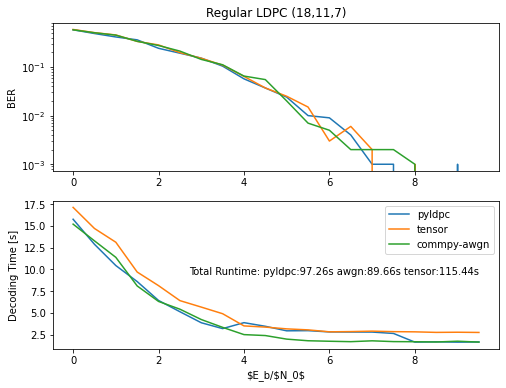

In [33]:
# Compare 3 AWGN(Tensorflow, CommPy, PYLDPC) Simulation on LDPC
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_pyldpc,'', label="pyldpc") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_tensor,'', label="tensor") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_awgn,'', label="commpy-awgn") # plot BER vs SNR

ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
ax2.set_xlabel('$E_b/$N_0$')
ax2.set_ylabel('Decoding Time [s]')
ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
            xy=(1, 0.35), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

<B>Conclussion:</B>
      It proved that tensorflow behaves similar to AWGN noise channel provided by pyldpc, commpy. But tensor flow based one takes adds little more time delay. This need to be offseted if we are comparing performance. 

In [34]:
# Define Model 

# input_message_length is initialized by ldpc encoder
CHANNEL_SIZE=2
input_message_length = 4
num_hidden_1 = CHANEL_SIZE
print ("input_message_length=", input_message_length)

input_message_x = tf.placeholder("float32", [None, input_message_length], name="input_message_x")
awgn_noise_std_dev_x = tf.placeholder("float32", name ="awgn_noise_std_dev")
input_channel_x = tf.placeholder("float32", [None, CHANEL_SIZE], name="input_channel_x")

weights = {
  "encoder_l1" : tf.Variable (tf.random_uniform([input_message_length, num_hidden_1], -1, 1), name="encoder_l1_weights"),
  "decoder_l1" : tf.Variable (tf.random_uniform([num_hidden_1, input_message_length], -1, 1), name="decoder_l1_weights"),
  "decoder_l2" : tf.Variable (tf.random_uniform([input_message_length, input_message_length], -1, 1), name="decoder_l2_weights"),
}

biases = {
  "encoder_l1" : tf.Variable (tf.random_uniform([num_hidden_1], -1,1), name="encoder_l1_bias"),
  "decoder_l1" : tf.Variable (tf.random_uniform([input_message_length], -1,1), name="decoder_l1_bias"),
  "decoder_l2" : tf.Variable (tf.random_uniform([input_message_length], -1,1), name="decoder_l2_bias"),
}

def dl_encoder (x):
  layer_1 = tf.nn.tanh (tf.matmul(x, weights['encoder_l1']) + biases['encoder_l1'])
  #layer_2 = tf.round(layer_1)
  
  layer_2 =  layer_1 / tf.sqrt(tf.reduce_mean(tf.square(layer_1)))

  #x = tf.sqrt(tf.reduce_sum(tf.square(layer_1), axis=1))
  #x = tf.reshape (x, (-1,1))
  #layer_2 = layer_1 / x

  #layer_2 =  tf.nn.relu(layer_1)
  return layer_2

#input_channel_x = tf.placeholder("float32", [None, 3], name="input_channel_x")
#x = tf.sqrt(tf.reduce_sum(tf.square(input_channel_x), axis=1))
#x = tf.reshape(x, (-1, 1))
#l = x
#l = input_channel_x / x
def dl_decoder (x):
  layer_1 = tf.nn.tanh (tf.matmul(x, weights['decoder_l1']) + biases['decoder_l1'])
  layer_2 = tf.nn.sigmoid (tf.matmul(layer_1, weights['decoder_l2']) + biases['decoder_l2'])
  return layer_2

def awgn_layer(x):
  awgn_noise = tf.random.normal(tf.shape(x), stddev=awgn_noise_std_dev_x,  name="awgn_noise")
  awgn_channel_output = tf.add(x, awgn_noise, name ="x_and_noise")
  return awgn_channel_output


dl_encoder_output = dl_encoder(input_message_x)
dl_decoder_input = awgn_layer(dl_encoder_output)
#awgn_noise = tf.random.normal(tf.shape(dl_encoder_output), stddev=awgn_noise_std_dev,  name="awgn_noise")
#dl_decoder_input = tf.add(dl_encoder_output, awgn_noise, name ="x_and_noise")
dl_decoder_output = dl_decoder (dl_decoder_input)
dl_decoder_only_output = dl_decoder(input_channel_x)


loss1 = tf.reduce_mean (-1 * (input_message_x*tf.log(dl_decoder_output) + (1 - input_message_x)*tf.log(1 - dl_decoder_output) ))
lr = tf.placeholder(dtype=tf.float32,shape=[])
rms_optimizer = tf.train.AdamOptimizer(learning_rate=0.00007).minimize (loss1)
rms_optimizer1 = tf.train.AdamOptimizer(learning_rate=0.0001).minimize (loss1)


awgn_channel_input = tf.compat.v1.placeholder(tf.float64, [CHANEL_SIZE])
awgn_noise_std_dev = tf.placeholder(tf.float64)
awgn_noise = tf.random.normal(tf.shape(awgn_channel_input), stddev=awgn_noise_std_dev, dtype=tf.dtypes.float64)
awgn_channel_output = tf.add(awgn_channel_input, awgn_noise)

input_message_length= 4


In [43]:
class GetOutOfLoop( Exception ):
    pass
batch_size = 50
training_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE*10,input_message_length))
print (training_input_message)
print (len(training_input_message))

# Training
train_init = tf.global_variables_initializer ()
train_sess = tf.Session ()

epochs = 20
outer_ephocs = 1
display_step = epochs/2
num_of_batches = len(training_input_message) / batch_size
print ("batch_size:", batch_size, "num_of_batcches:", num_of_batches)
train_sess.run(train_init)
l = 0
lrate = 0.1

try:
  for snr in (numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)):
    sigma = 1.0*Snr2Sigma (7)
    print ("Training for SNR=", snr, " sigma=", sigma) 
    if (snr < 6): opt = rms_optimizer1
    else : opt = rms_optimizer 
    for e in range(epochs):
      for j in range (int(num_of_batches)):
        x_train_batch = training_input_message [j*batch_size:(j+1)*batch_size]
        x_train_batch_float = x_train_batch.astype("float32")
        _, l = train_sess.run ([opt, loss1], feed_dict={input_message_x:x_train_batch_float, awgn_noise_std_dev_x:sigma, lr:lrate})
        if (l < 0.5): lrate = 0.001
        if (l < 0.25): lrate = 0.00001
        if (l < 0.1): lrate = 0.000001
        if (l < 0.07): lrate = 0.0000001
        if j % display_step == 0:
          print('Step %i: Minibatch Loss: %f' % (i*display_step+j, l))
        if (l < 0.0005): raise GetOutOfLoop
except GetOutOfLoop:
  print("Early Stop")

Streaming output truncated to the last 5000 lines.
Step 20120: Minibatch Loss: 0.036283
Step 20130: Minibatch Loss: 0.036496
Step 20140: Minibatch Loss: 0.036199
Step 20150: Minibatch Loss: 0.036160
Step 20160: Minibatch Loss: 0.036063
Step 20170: Minibatch Loss: 0.036135
Step 20180: Minibatch Loss: 0.036451
Step 19990: Minibatch Loss: 0.036025
Step 20000: Minibatch Loss: 0.035995
Step 20010: Minibatch Loss: 0.036006
Step 20020: Minibatch Loss: 0.036198
Step 20030: Minibatch Loss: 0.035956
Step 20040: Minibatch Loss: 0.035885
Step 20050: Minibatch Loss: 0.035833
Step 20060: Minibatch Loss: 0.035886
Step 20070: Minibatch Loss: 0.036103
Step 20080: Minibatch Loss: 0.035927
Step 20090: Minibatch Loss: 0.035818
Step 20100: Minibatch Loss: 0.035628
Step 20110: Minibatch Loss: 0.035727
Step 20120: Minibatch Loss: 0.035646
Step 20130: Minibatch Loss: 0.035795
Step 20140: Minibatch Loss: 0.035532
Step 20150: Minibatch Loss: 0.038570
Step 20160: Minibatch Loss: 0.035382
Step 20170: Minibatch Lo

In [44]:
#a = [[1,2],[3,4]]
#x=a/numpy.sqrt(numpy.sum(numpy.square(a),axis=1).reshape([2,1]))
#print (x)
#print (1/numpy.sqrt(5))
#print (x[0][0]**2+x[0][1]**2)

#input_channel_x = tf.placeholder("float32", [None, 2], name="input_channel_x")
#x = tf.sqrt(tf.reduce_sum(tf.square(input_channel_x), axis=1))
#x = tf.reshape(x, (-1, 1))
#l = x
#l = input_channel_x / x

#ans=train_sess.run ([l], feed_dict={input_channel_x:a})
#print (ans)

#print (ans[0][0]**2+ans[0][1]**2)

In [45]:
input_message_length = 4
input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE*10,input_message_length))
print (training_input_message)
print (len(training_input_message))

[[0 0 1 0]
 [1 0 0 0]
 [0 0 1 1]
 ...
 [0 1 1 0]
 [0 0 1 1]
 [1 0 1 0]]
10000


In [46]:
# Here I am using trained model
NUM_OF_INPUT_MESSAGE_BER = NUM_OF_INPUT_MESSAGE * 2
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_dl_tensor  = numpy.array(())
times_per_iter_dl_tensor = numpy.array(())

channel_x = []
channel_y = []
channel_n_x = []
channel_n_y = []

for snr in numpy.arange (0, 10, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  sigma = Snr2Sigma (snr)
  for i in range (NUM_OF_INPUT_MESSAGE_BER):
    input_message_xx = input_message [i:i+1]
    input_message_xx_float = input_message_xx.astype("float32")
    encoded_message = train_sess.run ([dl_encoder_output], feed_dict={input_message_x:input_message_xx_float})
    #print (encoded_message[0][0])
    channel_x.append(encoded_message[0][0][0])
    channel_y.append(encoded_message[0][0][1])
    awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message[0][0]})
    channel_n_x.append(awgn_channel_output_message[0][0])
    channel_n_y.append(awgn_channel_output_message[0][1])
    #print (awgn_channel_output_message)
    decoded_message = train_sess.run ([dl_decoder_only_output], feed_dict={input_channel_x:awgn_channel_output_message})
    #print ("input", input_message[i])
    decoded_message = numpy.around(decoded_message[0][0]).astype(int)
    #print ("output", decoded_message)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE_BER
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_dl_tensor=numpy.append(ber_per_iter_dl_tensor ,ber)
  times_per_iter_dl_tensor=numpy.append(times_per_iter_dl_tensor, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.32s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.59s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.86s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 1.12s
SNR: 0.000 - Iter: 1250 - Last 250.0 iterations took 1.37s
SNR: 0.000 - Iter: 1500 - Last 250.0 iterations took 1.63s
SNR: 0.000 - Iter: 1750 - Last 250.0 iterations took 1.89s
SNR: 0.000 - Iter: 2000 - Last 250.0 iterations took 2.17s
SNR: 0.000:
 -> BER: 0.07
 -> Total Time: 9.94s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.30s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.57s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.85s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 1.13s
SNR: 0.500 - Iter: 1250 - Last 250.0 iterations took 1.39s
SNR: 0.500 - Iter: 1500 - Last 250.0 iterations took 1.65s
SNR: 0.500 - Iter: 1750 - Last 250.0 iterations took 1.92s
SNR: 0.500 - Iter: 2000 - Last 250.0 iterations took 2.19s
SNR: 0.500:
 -

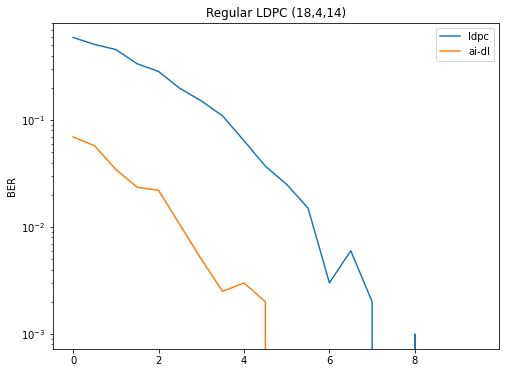

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1) = plt.subplots(1,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_tensor,'', label="ldpc") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor,'', label="ai-dl") # plot BER vs SNR
ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
#ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
#ax2.set_xlabel('$E_b/$N_0$')
#ax2.set_ylabel('Decoding Time [s]')
#ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
#            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
#            xy=(1, 0.35), xycoords='axes fraction',
#            xytext=(-20, 20), textcoords='offset pixels',
#            horizontalalignment='right',
#            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

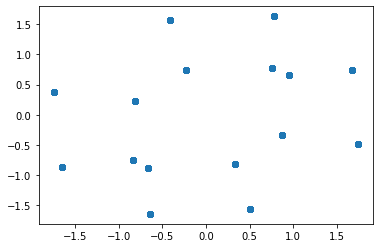

In [48]:
import matplotlib.pyplot as plt


plt.scatter(channel_x, channel_y)

plt.show()

In [49]:
print(channel_x)
print(channel_y)
print (channel_x[1]**2+channel_y[1]**2)

[0.50107294, -1.6493227, 0.50107294, -0.80809164, 1.7429188, 1.6714702, -1.7440997, 0.50107294, -0.41697645, -0.6440807, -0.2279968, 0.75649464, -0.2279968, -0.2279968, -1.7440997, 0.330445, 0.87090474, 1.6714702, 0.75649464, -0.6440807, 0.9549925, 0.50107294, 0.330445, 1.6714702, -0.8387963, 1.7429188, -0.41697645, -0.41697645, 0.330445, 0.50107294, 0.9549925, 1.6714702, 0.75649464, 0.9549925, 0.75649464, 0.330445, 1.7429188, 0.330445, -0.8387963, -1.6493227, 0.75649464, -1.7440997, 1.6714702, -0.6440807, 0.75649464, 0.87090474, 0.87090474, -0.8387963, 0.87090474, -0.6440807, 1.6714702, 0.87090474, 0.9549925, 0.50107294, 0.330445, -1.6493227, -0.8387963, -1.6493227, 0.75649464, -0.41697645, 0.75649464, -0.2279968, 1.7429188, 0.330445, -0.41697645, 0.77476686, -0.41697645, 0.50107294, -1.7440997, -0.8387963, 0.330445, -0.66885114, -0.8387963, 0.87090474, -0.6440807, 1.6714702, -0.41697645, -0.6440807, -0.6440807, -1.7440997, -0.2279968, 0.9549925, 0.330445, -0.6440807, 1.6714702, -0.80

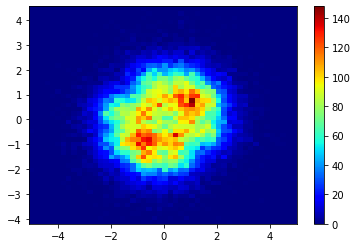

In [50]:
import matplotlib.pyplot as plt

#plt.scatter(channel_n_x, channel_n_y)
plt.hist2d(channel_n_x, channel_n_y, (50, 50), cmap=plt.cm.jet)
plt.colorbar()
plt.show()

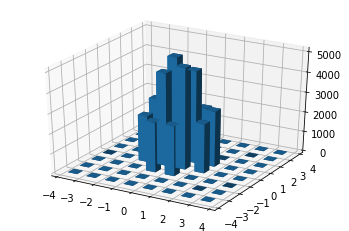

In [51]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
hist, xedges, yedges = np.histogram2d(channel_x, channel_y, bins=8, range=[[-4, 4], [-4, 4]])

# Construct arrays for the anchor positions of the 16 bars.
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = 0

# Construct arrays with the dimensions for the 16 bars.
dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average')

plt.show()

In [52]:
def bits2int(a, axis=-1):
    return numpy.right_shift(numpy.packbits(a, axis=axis), 8 - a.shape[axis]).squeeze()


def row_bits2int(arr):
    n = arr.shape[1]  # number of columns
    # shift the bits of the first column to the left by n - 1
    a = arr[:, 0] << n - 1  

    for j in range(1, n):
        # "overlay" with the shifted bits of the next column
        a |= arr[:, j] << n - 1 - j  
    return a

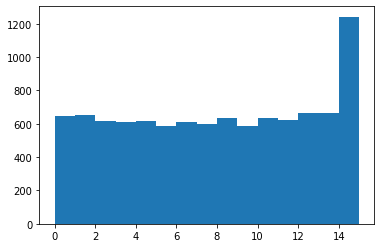

In [56]:
#input_message_length=8
training_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE*10,input_message_length))
training_input_message_decimal = row_bits2int(training_input_message)
#uniqueValues, indicesList = numpy.unique(training_input_message_decimal, return_index=True)
x_axis = numpy.arange(0,2**input_message_length)
y_axis = row_bits2int(training_input_message)
#x=numpy.histogram(training_input_message_decimal,bins = x_axis) 
plt.hist(training_input_message_decimal, bins = x_axis) 
plt.show()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]
[ 9 13  2 12  7  3  3 13 11 12  2 15 15  8  0 15  6  0  9  9  1  6 13 13
  0  5 13  4  9  6 14  6  5  6  3  8  3 10  1  4 10 10 10  4  0  8  5 13
  0  3  1 15  8 15  7  5 11  2  3  2 11  4  8 15 13 14  3 15 13 12  5  3
 10  9 10  7  3 15  0 10  3 11 12  0 11 12 11 12 12  9  9  1  8  6 15  4
  3 10  8 15]


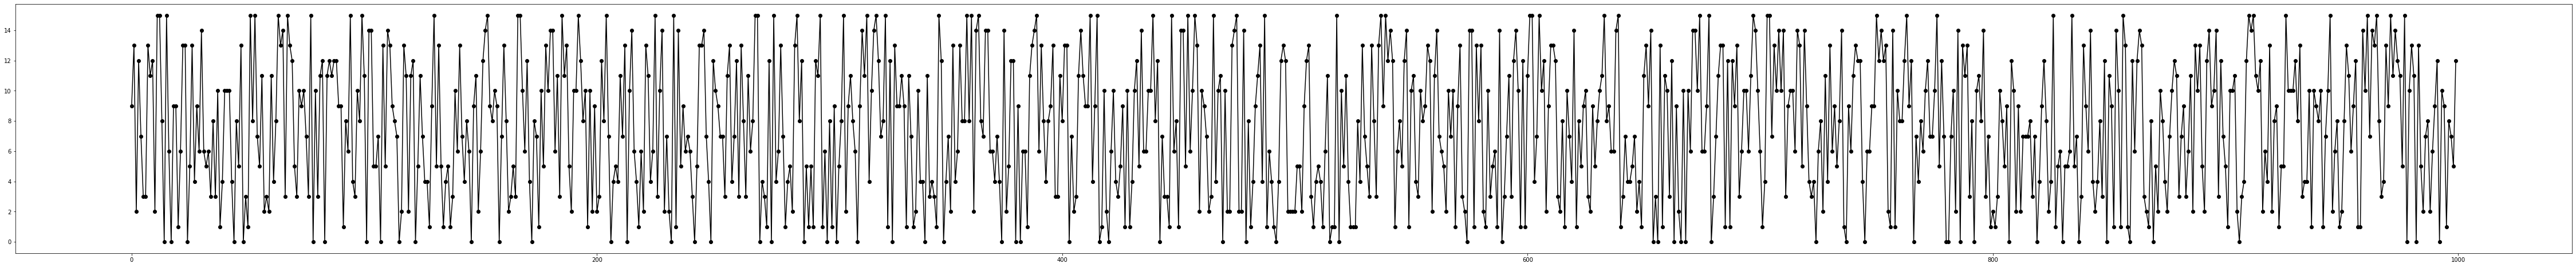

In [57]:
x_axis = numpy.arange(0,NUM_OF_INPUT_MESSAGE*10)
plt.figure(figsize=(80, 8))
plt.plot(x_axis[:NUM_OF_INPUT_MESSAGE],training_input_message_decimal[:NUM_OF_INPUT_MESSAGE], '-ok')
print (x_axis[:100])
print(training_input_message_decimal[:100])


In [ ]:
training_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,input_message_length))


In [60]:
# Here I am using trained model
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_dl_tensor  = numpy.array(())
times_per_iter_dl_tensor = numpy.array(())

for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  sigma = Snr2Sigma (snr)
  for i in range (NUM_OF_INPUT_MESSAGE):
    input_message_xx = training_input_message [i:i+1]
    input_message_xx_float = input_message_xx.astype("float32")
    encoded_message = train_sess.run ([dl_encoder_output], feed_dict={input_message_x:input_message_xx_float})
    #print (encoded_message[0][0])
    awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message[0][0]})
    #print (awgn_channel_output_message)
    decoded_message = train_sess.run ([dl_decoder_only_output], feed_dict={input_channel_x:awgn_channel_output_message})
    #print ("input", input_message[i])
    decoded_message = numpy.around(decoded_message[0][0]).astype(int)
    #print ("output", decoded_message)
    if abs(decoded_message-training_input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_dl_tensor=numpy.append(ber_per_iter_dl_tensor ,ber)
  times_per_iter_dl_tensor=numpy.append(times_per_iter_dl_tensor, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.26s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 0.51s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 0.77s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 1.03s
SNR: 0.000:
 -> BER: 0.07
 -> Total Time: 2.58s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.25s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 0.52s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 0.79s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 1.06s
SNR: 0.500:
 -> BER: 0.06
 -> Total Time: 2.63s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.25s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 0.51s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 0.77s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 1.04s
SNR: 1.000:
 -> BER: 0.04
 -> Total Time: 2.58s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.26s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 0.53s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

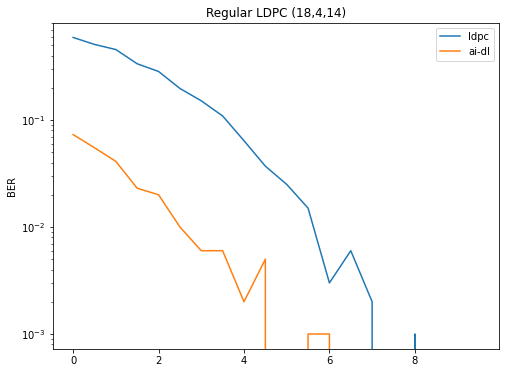

In [61]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1) = plt.subplots(1,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_tensor,'', label="ldpc") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor,'', label="ai-dl") # plot BER vs SNR
ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
#ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
#ax2.set_xlabel('$E_b/$N_0$')
#ax2.set_ylabel('Decoding Time [s]')
#ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
#            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
#            xy=(1, 0.35), xycoords='axes fraction',
#            xytext=(-20, 20), textcoords='offset pixels',
#            horizontalalignment='right',
#            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()